<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Data-Acquisition" data-toc-modified-id="Data-Acquisition-0.1">Data Acquisition</a></span></li><li><span><a href="#Data-Preparation" data-toc-modified-id="Data-Preparation-0.2">Data Preparation</a></span></li><li><span><a href="#Data-Enrichment" data-toc-modified-id="Data-Enrichment-0.3">Data Enrichment</a></span><ul class="toc-item"><li><span><a href="#IP-Geolocation-Enrichment" data-toc-modified-id="IP-Geolocation-Enrichment-0.3.1">IP Geolocation Enrichment</a></span></li><li><span><a href="#Whois-registration-enrichment" data-toc-modified-id="Whois-registration-enrichment-0.3.2">Whois registration enrichment</a></span></li><li><span><a href="#ThreatIntel-Enrichment" data-toc-modified-id="ThreatIntel-Enrichment-0.3.3">ThreatIntel Enrichment</a></span></li></ul></li><li><span><a href="#Data-Analysis" data-toc-modified-id="Data-Analysis-0.4">Data Analysis</a></span><ul class="toc-item"><li><span><a href="#How-was-the-distribution-of-alerts-over-the-time-period-?" data-toc-modified-id="How-was-the-distribution-of-alerts-over-the-time-period-?-0.4.1">How was the distribution of alerts over the time period ?</a></span></li><li><span><a href="#How-many-unique-IPs-seen-accessing-the-bucket-?" data-toc-modified-id="How-many-unique-IPs-seen-accessing-the-bucket-?-0.4.2">How many unique IPs seen accessing the bucket ?</a></span></li><li><span><a href="#What-type-of-API--Events-seen-?" data-toc-modified-id="What-type-of-API--Events-seen-?-0.4.3">What type of API  Events seen ?</a></span></li><li><span><a href="#Which-top-5-user-agents-seen-in-the-alerts-?" data-toc-modified-id="Which-top-5-user-agents-seen-in-the-alerts-?-0.4.4">Which top 5 user agents seen in the alerts ?</a></span></li><li><span><a href="#Which-top-5-Countries-seen-in-the-dataset-?" data-toc-modified-id="Which-top-5-Countries-seen-in-the-dataset-?-0.4.5">Which top 5 Countries seen in the dataset ?</a></span></li><li><span><a href="#Were-there-any-repeat-Ip-Addresses/-From-the-same-ASN/Registrar-?" data-toc-modified-id="Were-there-any-repeat-Ip-Addresses/-From-the-same-ASN/Registrar-?-0.4.6">Were there any repeat Ip Addresses/ From the same ASN/Registrar ?</a></span></li><li><span><a href="#How-many-Ips-were-flagged-as-bad-by-Open-Source-ThreatIntel-and-what-categories-?" data-toc-modified-id="How-many-Ips-were-flagged-as-bad-by-Open-Source-ThreatIntel-and-what-categories-?-0.4.7">How many Ips were flagged as bad by Open Source ThreatIntel and what categories ?</a></span></li></ul></li><li><span><a href="#Data-Visualization" data-toc-modified-id="Data-Visualization-0.5">Data Visualization</a></span><ul class="toc-item"><li><span><a href="#GeoIP-map-using-Folium" data-toc-modified-id="GeoIP-map-using-Folium-0.5.1">GeoIP map using Folium</a></span></li></ul></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-1">Conclusion</a></span></li></ul></div>

## Data Acquisition

Dataset is retrieved using third party service [BreachInsider](https://dashboard.breachinsider.com/honey-buckets/) which lets you create AWS S3 Honeybucket for free and alerts you whenever someone accesses it. 

You can read more about the service in the blog [Honey Buckets — Find out who is snooping through your Amazon S3 buckets.](https://breachinsider.com/blog/honey-buckets-find-out-who-is-snooping-through-your-amazon-s3-buckets/)


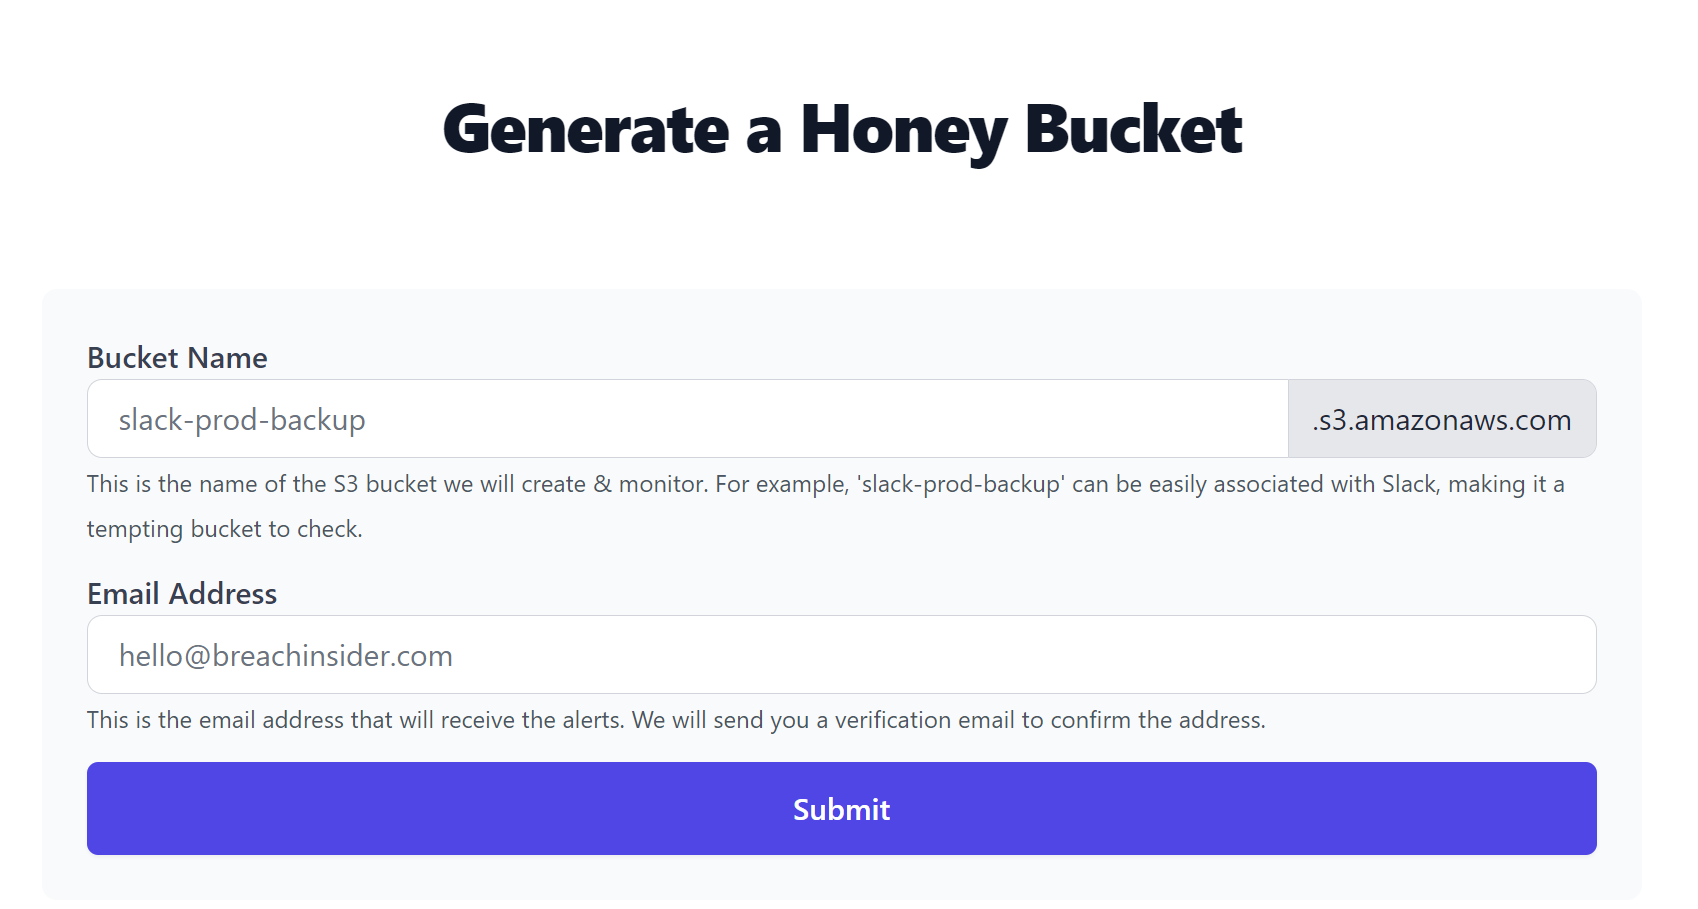

Whenever someone discovers and accesses this honeybucket, you will get email notification with link to dashboard.
When you click on an alert received in an email, it shows you all the historical logs on single page. We registered a honeybucket named `microsoft-devtest` in `2020-02-07 23:02 UTC` to collect some telemetry. 
All of the logs from the dashboard are stored in a text file `AWSHoneyBucketLogs.txt`

## Data Preparation

Even though the logs are available in central location, unfortunately they are not in strucutured json file so we have to clean and prepare data in order to do the analysis. We can use powerful data analysis features of python to format and prepare the data for analysis.

Sample alert from the central link shown as below. 

```
    AWS Request Details
    Event Type
    AwsApiCall
    Event Name
    ListObjects
    Request ID
    CD5DFA0584AAC93D
    Request User Agent
    Ruby
    User ID
    {'type': 'AWSAccount', 'principalId': '', 'accountId': 'ANONYMOUS_PRINCIPAL'}
    Request Parameters
    {'bucketName': 'microsoft-devtest', 'Host': 'microsoft-devtest.s3.amazonaws.com'}
    Alert #3 – 2020-02-11T03:33:15Z
    Event ID: ccfe0554-89cf-42c8-931a-ac1e5ee6b30c
    Event DateTime
    2020-02-11T03:33:15Z
    Alarm DateTime
    2020-02-11T03:35:42.025640+00:00
    Source IP
    34.68.153.199
    Request User Agent
    python-requests/2.22.0
    Repeated Attempts
    1
```

As you can see the data is not structured and can not be used for analysis. 
Below are summary of data cleaning steps performed.
 - Each log is on new line and separated by AWS Request Details.
 - key value pairs are not in uniform and on newline  - added regex replace to make it key value pairs
 - couple of alerts have additional field related to access errors - those are removed, will separately flag them.
 - Once the data is in right format with  key value pairs are created - it is transformed into json in an array format.
 - all the alerts are sequentially stored as list of dictionaries which are then converted in to dataframe.

In [1]:
import json
import re
import pprint
import pandas as pd

logfile_name = "./data/AWSHoneyBucketLogs.txt"

with open(logfile_name, "r") as f:
    input_logs = f.read()

print(f"Total no of lines in the log file: {len(input_logs)}")

Total no of lines in the log file: 164297


In [2]:
def clean_logfile(logfile_name):
    "Function to spllit each alert and find and replace to create dictionary like key-value pairs"
    print("Splitting individiual alerts...")
    s3log_records = re.split("AWS Request Details", input_logs)
    s3clean_logs = []
    print("Find and replace the data into clean unified format...")
    # Excluding first and last event which are not access alerts
    for logs in s3log_records[1:-1]:       
        logs = re.sub("Event Type\n", "Event Type:", logs)
        logs = re.sub("Event Name\n", "Event Name:", logs)
        logs = re.sub("Request ID\n", "Request ID:", logs)
        logs = re.sub("Request User Agent\n", "Request User Agent:", logs)
        logs = re.sub("User ID\n", "User ID:", logs)
        logs = re.sub("Request Parameters\n", "Request Parameters:", logs)
        logs = re.sub("Alert #", "Alert: ", logs)
        logs = re.sub("Event ID: ", "Event ID:", logs)
        logs = re.sub("Event DateTime\n", "Event DateTime:", logs)
        logs = re.sub("Alarm DateTime\n", "Alarm DateTime:", logs)
        logs = re.sub("Source IP\n", "Source IP:", logs)
        logs = re.sub("Repeated Attempts\n", "Repeated Attempts:", logs)
        logs = re.sub("Request User Agent:.*", "", logs, 1)
        logs = re.sub("Error Code", "", logs, 1)
        logs = re.sub("AccessDenied", "", logs, 1)
        logs = re.sub("Error Message", "", logs, 1)
        logs = re.sub("Access Denied", "", logs, 1)
        s3clean_logs.append(logs)
    return s3clean_logs


def create_dicts(clean_logfile):
    "Function to create key value pairs and return list of json records"
    list_of_json_records = []
    print("\nCreating dictionary pairs from clean dataset...")
    for event in clean_logfile:
        clean_logfile = event.split("\n")
        # remove empty strings
        clean_logfile = [i for i in clean_logfile if i]
        parsed_dict = {}
        for line in clean_logfile:
            # Creating key value pairs and adding to dictionary
            key, value = line.split(":", 1)
            parsed_dict[key] = value
        list_of_json_records.append(parsed_dict)
    return list_of_json_records


s3clean_logs = clean_logfile(logfile_name)
list_of_json_records = create_dicts(s3clean_logs)

print(f"\nTotal no of Alerts from original logs: {len(list_of_json_records)}")

Splitting individiual alerts...
Find and replace the data into clean unified format...

Creating dictionary pairs from clean dataset...

Total no of Alerts from original logs: 263


In [3]:
print(f"\n Displaying sample alert post cleaning: \n")
pprint.pprint(list_of_json_records[0])


 Displaying sample alert post cleaning: 

{'Alarm DateTime': '2022-01-31T14:39:09.605190+00:00',
 'Alert': ' 263 – 2022-01-31T14:38:27Z',
 'Event DateTime': '2022-01-31T14:38:27Z',
 'Event ID': '7e75ac66-2d6f-4a2c-8921-489be88c65b1',
 'Event Name': 'ListObjects',
 'Event Type': 'AwsApiCall',
 'Repeated Attempts': '1',
 'Request ID': 'DBHD1NBK6P65FE8B',
 'Request Parameters': "{'list-type': '2', 'bucketName': 'microsoft-devtest', "
                       "'Host': 'microsoft-devtest.s3.amazonaws.com', "
                       "'encoding-type': 'url'}",
 'Request User Agent': 'Boto3/1.17.40 Python/3.6.12 '
                       'Linux/3.10.0-1160.6.1.el7.x86_64 Botocore/1.20.112',
 'Source IP': '212.83.184.14',
 'User ID': "{'type': 'AWSAccount', 'principalId': '', 'accountId': "
            "'ANONYMOUS_PRINCIPAL'}"}


In [4]:
#Load list of JSON records into dataframe
df = pd.DataFrame(list_of_json_records)

df.head()

,Event Type,Event Name,Request ID,User ID,Request Parameters,Alert,Event ID,Event DateTime,Alarm DateTime,Source IP,Request User Agent,Repeated Attempts
0,AwsApiCall,ListObjects,DBHD1NBK6P65FE8B,"{'type': 'AWSAccount', 'principalId': '', 'acc...","{'list-type': '2', 'bucketName': 'microsoft-de...",263 – 2022-01-31T14:38:27Z,7e75ac66-2d6f-4a2c-8921-489be88c65b1,2022-01-31T14:38:27Z,2022-01-31T14:39:09.605190+00:00,212.83.184.14,Boto3/1.17.40 Python/3.6.12 Linux/3.10.0-1160....,1
1,AwsApiCall,ListObjects,YRJ65RPXZNGK7VQH,"{'type': 'AWSAccount', 'principalId': '', 'acc...","{'list-type': '2', 'bucketName': 'microsoft-de...",262 – 2022-01-31T03:54:25Z,155a578b-56df-4159-84de-df7d57ddf26c,2022-01-31T03:54:25Z,2022-01-31T03:58:26.275480+00:00,88.218.82.128,Java/1.8.0_201,1
2,AwsApiCall,HeadBucket,JYSHBKCE4J9DS8K5,"{'type': 'AWSAccount', 'principalId': '', 'acc...","{'bucketName': 'microsoft-devtest', 'Host': 'm...",261 – 2022-01-30T18:28:31Z,42dd41f1-93cb-4085-8342-c7b4ec499a79,2022-01-30T18:28:31Z,2022-01-30T18:29:57.302040+00:00,212.83.184.16,Boto3/1.17.40 Python/3.6.12 Linux/3.10.0-1160....,1
3,AwsApiCall,ListObjects,66PHY3JF14ANGJH8,"{'type': 'AWSAccount', 'principalId': '', 'acc...","{'list-type': '2', 'bucketName': 'microsoft-de...",260 – 2022-01-30T14:28:44Z,33143f5e-4d85-4827-b1c8-1900763febba,2022-01-30T14:28:44Z,2022-01-30T14:32:14.020955+00:00,212.83.184.15,Boto3/1.17.40 Python/3.6.12 Linux/3.10.0-1160....,1
4,AwsApiCall,ListObjects,PCM2P7FSY5DFW99M,"{'type': 'AWSAccount', 'principalId': '', 'acc...","{'list-type': '2', 'bucketName': 'microsoft-de...",259 – 2022-01-29T18:03:13Z,dff8e5ab-baa3-43ff-8023-596064565ef4,2022-01-29T18:03:13Z,2022-01-29T18:07:30.430153+00:00,212.83.184.15,Boto3/1.17.40 Python/3.6.12 Linux/3.10.0-1160....,1


## Data Enrichment

In [5]:
import IPython
import pandas as pd
from pathlib import Path
from ipywidgets import widgets, Layout
from IPython.display import display, HTML

REQ_PYTHON_VER=(3, 6)
REQ_MSTICPY_VER=(1, 4, 4)

display(HTML("<h3>Starting Notebook setup...</h3>"))
if Path("./utils/nb_check.py").is_file():
    from utils.nb_check import check_python_ver, check_mp_ver

    check_python_ver(min_py_ver=REQ_PYTHON_VER)
    try:
        check_mp_ver(min_msticpy_ver=REQ_MSTICPY_VER)
    except ImportError:
        !pip install --upgrade msticpy
        if "msticpy" in sys.modules:
            importlib.reload(sys.modules["msticpy"])
        else:
            import msticpy
        check_mp_ver(REQ_MSTICPY_VER)

# If not using Azure Notebooks, install msticpy with
# !pip install msticpy
from msticpy import init_notebook

extra_imports = [
    "msticpy.nbtools.nbdisplay, draw_alert_entity_graph",
    "msticpy.sectools.ip_utils, convert_to_ip_entities",
    "msticpy.nbtools.ti_browser, browse_results",
    "IPython.display, Image",
    "msticpy.sectools.ip_utils, get_whois_info",
    "msticpy.sectools.ip_utils, get_ip_type"
]

init_notebook(
    namespace=globals(),
    extra_imports=extra_imports,
);

### IP Geolocation Enrichment
In this step, we will use msticpy geolocation capabilities using maxmind database. You will need maxmind API key to download the database.

<div style="border: solid; padding: 5pt"><b>Note:</b>
You may see the GeoLite driver downloading its database the first time you run this.
</div>
<br>
<details>
    <summary>Learn more about MSTICPy GeoIP providers...</summary>
    <p>
    <a href=https://msticpy.readthedocs.io/en/latest/data_acquisition/GeoIPLookups.html >MSTICPy GeoIP Providers</a>
    </p>
</details>
<br>

In [6]:
from msticpy.sectools.geoip import GeoLiteLookup

iplocation = GeoLiteLookup()

df_enriched = iplocation.df_lookup_ip(df, column="Source IP")
df_enriched.head()

,Event Type,Event Name,Request ID,User ID,Request Parameters,Alert,Event ID,Event DateTime,Alarm DateTime,Source IP,Request User Agent,Repeated Attempts,CountryCode,CountryName,State,City,Longitude,Latitude,TimeGenerated,Type,IpAddress
0,AwsApiCall,ListObjects,DBHD1NBK6P65FE8B,"{'type': 'AWSAccount', 'principalId': '', 'accountId': 'ANONYMOUS_PRINCIPAL'}","{'list-type': '2', 'bucketName': 'microsoft-devtest', 'Host': 'microsoft-devtest.s3.amazonaws.co...",263 – 2022-01-31T14:38:27Z,7e75ac66-2d6f-4a2c-8921-489be88c65b1,2022-01-31T14:38:27Z,2022-01-31T14:39:09.605190+00:00,212.83.184.14,Boto3/1.17.40 Python/3.6.12 Linux/3.10.0-1160.6.1.el7.x86_64 Botocore/1.20.112,1,FR,France,Île-de-France,Nogent-sur-Marne,2.4836,48.8315,2022-02-01 07:54:31.555761,geolocation,212.83.184.14
1,AwsApiCall,ListObjects,DBHD1NBK6P65FE8B,"{'type': 'AWSAccount', 'principalId': '', 'accountId': 'ANONYMOUS_PRINCIPAL'}","{'list-type': '2', 'bucketName': 'microsoft-devtest', 'Host': 'microsoft-devtest.s3.amazonaws.co...",263 – 2022-01-31T14:38:27Z,7e75ac66-2d6f-4a2c-8921-489be88c65b1,2022-01-31T14:38:27Z,2022-01-31T14:39:09.605190+00:00,212.83.184.14,Boto3/1.17.40 Python/3.6.12 Linux/3.10.0-1160.6.1.el7.x86_64 Botocore/1.20.112,1,FR,France,Île-de-France,Nogent-sur-Marne,2.4836,48.8315,2022-02-01 07:54:31.561335,geolocation,212.83.184.14
2,AwsApiCall,ListObjects,DBHD1NBK6P65FE8B,"{'type': 'AWSAccount', 'principalId': '', 'accountId': 'ANONYMOUS_PRINCIPAL'}","{'list-type': '2', 'bucketName': 'microsoft-devtest', 'Host': 'microsoft-devtest.s3.amazonaws.co...",263 – 2022-01-31T14:38:27Z,7e75ac66-2d6f-4a2c-8921-489be88c65b1,2022-01-31T14:38:27Z,2022-01-31T14:39:09.605190+00:00,212.83.184.14,Boto3/1.17.40 Python/3.6.12 Linux/3.10.0-1160.6.1.el7.x86_64 Botocore/1.20.112,1,FR,France,Île-de-France,Nogent-sur-Marne,2.4836,48.8315,2022-02-01 07:54:31.563275,geolocation,212.83.184.14
3,AwsApiCall,ListObjects,DBHD1NBK6P65FE8B,"{'type': 'AWSAccount', 'principalId': '', 'accountId': 'ANONYMOUS_PRINCIPAL'}","{'list-type': '2', 'bucketName': 'microsoft-devtest', 'Host': 'microsoft-devtest.s3.amazonaws.co...",263 – 2022-01-31T14:38:27Z,7e75ac66-2d6f-4a2c-8921-489be88c65b1,2022-01-31T14:38:27Z,2022-01-31T14:39:09.605190+00:00,212.83.184.14,Boto3/1.17.40 Python/3.6.12 Linux/3.10.0-1160.6.1.el7.x86_64 Botocore/1.20.112,1,FR,France,Île-de-France,Nogent-sur-Marne,2.4836,48.8315,2022-02-01 07:54:31.568668,geolocation,212.83.184.14
4,AwsApiCall,ListObjects,YRJ65RPXZNGK7VQH,"{'type': 'AWSAccount', 'principalId': '', 'accountId': 'ANONYMOUS_PRINCIPAL'}","{'list-type': '2', 'bucketName': 'microsoft-devtest', 'Host': 'microsoft-devtest.s3.amazonaws.co...",262 – 2022-01-31T03:54:25Z,155a578b-56df-4159-84de-df7d57ddf26c,2022-01-31T03:54:25Z,2022-01-31T03:58:26.275480+00:00,88.218.82.128,Java/1.8.0_201,1,LA,Laos,Vientiane Prefecture,Vientiane,102.5987,17.9641,2022-02-01 07:54:31.556879,geolocation,88.218.82.128


### Whois registration enrichment
In this step, we can perform whois lokup on all public Source ips and populate additional information such as ASN.  This step can take from 12-15 mins as it will process 213 Ips
You can use this output to further filter known ASNs from the results.

In [7]:
num_ips = len(df_enriched["Source IP"].unique())
print(f"Performing WhoIs lookups for {num_ips} IPs ", end="")
df_enriched["SourceASN"] = df_enriched.apply(
    lambda x: get_whois_info(x["Source IP"], True), axis=1
)
df_enriched["SourceASNFull"] = df_enriched.apply(lambda x: x.SourceASN[1], axis=1)
df_enriched["SourceASN"] = df_enriched.apply(lambda x: x.SourceASN[0], axis=1)

# Display results
df_enriched.head()

Performing WhoIs lookups for 213 IPs ....................................................................................................................................................................................................................

,Event Type,Event Name,Request ID,User ID,Request Parameters,Alert,Event ID,Event DateTime,Alarm DateTime,Source IP,Request User Agent,Repeated Attempts,CountryCode,CountryName,State,City,Longitude,Latitude,TimeGenerated,Type,IpAddress,SourceASN,SourceASNFull
0,AwsApiCall,ListObjects,DBHD1NBK6P65FE8B,"{'type': 'AWSAccount', 'principalId': '', 'accountId': 'ANONYMOUS_PRINCIPAL'}","{'list-type': '2', 'bucketName': 'microsoft-devtest', 'Host': 'microsoft-devtest.s3.amazonaws.co...",263 – 2022-01-31T14:38:27Z,7e75ac66-2d6f-4a2c-8921-489be88c65b1,2022-01-31T14:38:27Z,2022-01-31T14:39:09.605190+00:00,212.83.184.14,Boto3/1.17.40 Python/3.6.12 Linux/3.10.0-1160.6.1.el7.x86_64 Botocore/1.20.112,1,FR,France,Île-de-France,Nogent-sur-Marne,2.4836,48.8315,2022-02-01 07:54:31.555761,geolocation,212.83.184.14,"Online SAS, FR","{'nir': None, 'asn_registry': 'ripencc', 'asn': '12876', 'asn_cidr': '212.83.160.0/19', 'asn_cou..."
1,AwsApiCall,ListObjects,DBHD1NBK6P65FE8B,"{'type': 'AWSAccount', 'principalId': '', 'accountId': 'ANONYMOUS_PRINCIPAL'}","{'list-type': '2', 'bucketName': 'microsoft-devtest', 'Host': 'microsoft-devtest.s3.amazonaws.co...",263 – 2022-01-31T14:38:27Z,7e75ac66-2d6f-4a2c-8921-489be88c65b1,2022-01-31T14:38:27Z,2022-01-31T14:39:09.605190+00:00,212.83.184.14,Boto3/1.17.40 Python/3.6.12 Linux/3.10.0-1160.6.1.el7.x86_64 Botocore/1.20.112,1,FR,France,Île-de-France,Nogent-sur-Marne,2.4836,48.8315,2022-02-01 07:54:31.561335,geolocation,212.83.184.14,"Online SAS, FR","{'nir': None, 'asn_registry': 'ripencc', 'asn': '12876', 'asn_cidr': '212.83.160.0/19', 'asn_cou..."
2,AwsApiCall,ListObjects,DBHD1NBK6P65FE8B,"{'type': 'AWSAccount', 'principalId': '', 'accountId': 'ANONYMOUS_PRINCIPAL'}","{'list-type': '2', 'bucketName': 'microsoft-devtest', 'Host': 'microsoft-devtest.s3.amazonaws.co...",263 – 2022-01-31T14:38:27Z,7e75ac66-2d6f-4a2c-8921-489be88c65b1,2022-01-31T14:38:27Z,2022-01-31T14:39:09.605190+00:00,212.83.184.14,Boto3/1.17.40 Python/3.6.12 Linux/3.10.0-1160.6.1.el7.x86_64 Botocore/1.20.112,1,FR,France,Île-de-France,Nogent-sur-Marne,2.4836,48.8315,2022-02-01 07:54:31.563275,geolocation,212.83.184.14,"Online SAS, FR","{'nir': None, 'asn_registry': 'ripencc', 'asn': '12876', 'asn_cidr': '212.83.160.0/19', 'asn_cou..."
3,AwsApiCall,ListObjects,DBHD1NBK6P65FE8B,"{'type': 'AWSAccount', 'principalId': '', 'accountId': 'ANONYMOUS_PRINCIPAL'}","{'list-type': '2', 'bucketName': 'microsoft-devtest', 'Host': 'microsoft-devtest.s3.amazonaws.co...",263 – 2022-01-31T14:38:27Z,7e75ac66-2d6f-4a2c-8921-489be88c65b1,2022-01-31T14:38:27Z,2022-01-31T14:39:09.605190+00:00,212.83.184.14,Boto3/1.17.40 Python/3.6.12 Linux/3.10.0-1160.6.1.el7.x86_64 Botocore/1.20.112,1,FR,France,Île-de-France,Nogent-sur-Marne,2.4836,48.8315,2022-02-01 07:54:31.568668,geolocation,212.83.184.14,"Online SAS, FR","{'nir': None, 'asn_registry': 'ripencc', 'asn': '12876', 'asn_cidr': '212.83.160.0/19', 'asn_cou..."
4,AwsApiCall,ListObjects,YRJ65RPXZNGK7VQH,"{'type': 'AWSAccount', 'principalId': '', 'accountId': 'ANONYMOUS_PRINCIPAL'}","{'list-type': '2', 'bucketName': 'microsoft-devtest', 'Host': 'microsoft-devtest.s3.amazonaws.co...",262 – 2022-01-31T03:54:25Z,155a578b-56df-4159-84de-df7d57ddf26c,2022-01-31T03:54:25Z,2022-01-31T03:58:26.275480+00:00,88.218.82.128,Java/1.8.0_201,1,LA,Laos,Vientiane Prefecture,Vientiane,102.5987,17.9641,2022-02-01 07:54:31.556879,geolocation,88.218.82.128,"M247, GB","{'nir': None, 'asn_registry': 'ripencc', 'asn': '9009', 'asn_cidr': '88.218.82.0/24', 'asn_count..."


### ThreatIntel Enrichment

In this step, we can perform threatintel lookup using msticpy and open source TI providers such as IBM Xforce, VirusTotal, Greynoise etc. 
Below example shows performing lookup on single IP as well as bulk lookup on all ips using IBM Xforce TI Provider. 
<br>You will need to register with IBM Xforce and enter API keys into `mstipyconfig.yaml`

<details>
    <summary>Learn more...</summary>
    <p>
    </p>
    <ul>     
        <li><a href=https://msticpy.readthedocs.io/en/latest/data_acquisition/TIProviders.html >Threat Intel Lookups in MSTICPy</a></li>
    </ul>
</details>
<br>

In [8]:
ti_lookup = TILookup()
# Perform lookup on single IOC
result = ti_lookup.lookup_ioc(observable="212.83.184.14", providers=["XForce"])
ti_lookup.result_to_df(result)

,Ioc,IocType,QuerySubtype,Provider,Result,Severity,Details,RawResult,Reference,Status
XForce,212.83.184.14,ipv4,None,XForce,True,information,"{'score': 1, 'cats': {}, 'categoryDescriptions': {}, 'reason': 'Regional Internet Registry', 're...","{'ip': '212.83.184.14', 'history': [{'created': '2012-03-22T07:26:00.000Z', 'reason': 'Regional ...",https://api.xforce.ibmcloud.com/ipr/212.83.184.14,0


In [9]:
# Flattening all the desnation IPs into comma separated list
ip_list = df_enriched["Source IP"].astype(str).values.flatten().tolist()

# Perform bulk lookup on all IPs with specified providers
ti_resp = ti_lookup.lookup_iocs(data=ip_list, providers=["OTX", "XForce"])

In [10]:
select_ti = browse_results(ti_resp, severities=['high','warning'])
select_ti

## Data Analysis

### How was the distribution of alerts over the time period ?

In [11]:
# Changing data type to datetime
df_enriched["Event DateTime"] = pd.to_datetime(df_enriched["Event DateTime"])

# Resamplling the dataframe and aggreagte by Month
df_enriched["Event DateTime"].groupby(
    [df_enriched["Event DateTime"].dt.year, df_enriched["Event DateTime"].dt.month]
).agg({"count"})

count
Event DateTime Event DateTime       
2020           2                   5
               5                   1
               6                   4
               7                  22
               8                   8
               9                   6
               10                  5
               11                  3
               12                  6
2021           1                   6
               2                  11
               3                  23
               4                  21
               5                  16
               6                  15
               7                  23
               8                  13
               9                  29
               10                 27
               11                 15
               12                 24
2022           1                 232

### How many unique IPs seen accessing the bucket ?

In [12]:
print(f"No of Unique IP addresses seen: {len(df_enriched['Source IP'].unique())}")

No of Unique IP addresses seen: 213


### What type of API  Events seen ?

In [13]:
df_enriched['Event Name'].value_counts()

ListObjects    312
HeadBucket     192
PutObject       11
Name: Event Name, dtype: int64

### Which top 5 user agents seen in the alerts ?

In [14]:
df_enriched['Request User Agent'].value_counts().head(5)

Boto3/1.17.40 Python/3.6.12 Linux/3.10.0-1160.6.1.el7.x86_64 Botocore/1.20.112    214
Go-http-client/1.1                                                                131
Java/1.8.0_201                                                                     16
aws-cli/1.17.9 Python/3.6.0 Windows/10 botocore/1.14.9                             12
Ruby                                                                               10
Name: Request User Agent, dtype: int64

### Which top 5 Countries seen in the dataset ?

In [15]:
df_enriched['CountryName'].value_counts().head(5)

France           217
Belgium           61
United States     32
Finland           23
India             20
Name: CountryName, dtype: int64

### Were there any repeat Ip Addresses/ From the same ASN/Registrar ?

In [16]:
# Repeat IP Addresses
df_grouped = df_enriched.groupby(['Source IP'])['Source IP'].agg({'count'})

df_grouped[df_grouped['count'] > 1].sort_values(by='count', ascending=False)

,count
Source IP,
212.83.184.15,121
212.83.184.17,64
212.83.184.14,16
43.251.92.37,16
188.40.66.118,9
212.83.184.16,9
35.205.104.93,9
34.77.163.42,9
104.155.101.3,4


In [17]:
# Repeat IP Addresses
df_asngrouped = df_enriched.groupby(['SourceASN'])['Source IP'].agg({'count'})

df_asngrouped[df_asngrouped['count'] > 1].sort_values(by='count', ascending=False)

,count
SourceASN,
"Online SAS, FR",214
"M247, GB",93
"GOOGLE, US",69
"HETZNER-AS, DE",34
"ANINETWORK-IN Ani Network Pvt Ltd, IN",16
"IWEB-AS, CA",15
"HOSTROYALE, IN",10
"ASDETUK www.heficed.com, GB",7
"AMAZON-AES, US",6


### How many Ips were flagged as bad by Open Source ThreatIntel and what categories ?

In [18]:
ti_resp.groupby(['Severity', 'Provider'])['Ioc'].agg({'count'})

count
Severity    Provider       
high        OTX          79
            XForce       21
information OTX         421
            XForce      492
warning     OTX          15
            XForce        2

## Data Visualization
MSTICpy also includes a feature to allow you to map locations, this can be particularily useful when looking at the distribution of remote network connections or other events. Below we plot the locations of Source IPs observed in our rlogs who accessed AWS S3 Honeybucket.

### GeoIP map using Folium

In [19]:
from msticpy.nbtools import entityschema
from msticpy.sectools.ip_utils import convert_to_ip_entities
from msticpy.nbtools.foliummap import FoliumMap, get_map_center

# Create a IP Geolookup class
iplocation = GeoLiteLookup()

folium_map = FoliumMap()

def format_ip_entity(row, ip_col):
    ip_entity = entities.IpAddress(Address=row[ip_col])
    iplocation.lookup_ip(ip_entity=ip_entity)
    if "severity" in row:
        ip_entity.AdditionalData["threat severity"] = row["severity"]
    return ip_entity

# Filtering high and warning Ips to display on Geomap
ti_resp_threats = ti_resp[ti_resp.Severity.isin(["high", "warning"])]

ips_threats = list(ti_resp_threats.apply(lambda x: format_ip_entity(x, "Ioc"), axis=1))

# Convert our IP addresses in string format into an ip address entity
ip_entity = entityschema.IpAddress()
ip_list = [convert_to_ip_entities(i)[0] for i in ti_resp_threats['Ioc']]
    
# Get center location of all IP locaitons to center the map on
location = get_map_center(ip_list)
s3bucket_map = FoliumMap(location=location, zoom_start=2)

# Add location markers to our map and dsiplay it
if len(ip_list) > 0:
    icon_props = {"color": "red"}
    s3bucket_map.add_ip_cluster(ip_entities=ips_threats, **icon_props)
    
display(s3bucket_map.folium_map)

# Conclusion

We used third party service BreachInsider to set up AWS S3 Honeybucket for free. The service offers central text files with the logging telemetry however it is not in structured fashion so we used Jupyter notebook and python to convert that text file into structured json file to do further analysis. 

Once the data is prepared, we can start analyzing various access patterns such as frequent user agents , 
source IPs etc. We also used msticpy data enrichment modules on IPs to populate additional data such as GeoLocation, IP ASN and registrar information. We also processed all the Public IPs against Open Source ThreatIntel providers such as IBM XForce and Alienvault OTX and found majority of the IP addresses categorized as bad and known to visit Honeypots or scanners etc.
This notebook along with real world dataset can be used as demonstration to analyze reconnaisance activity on publicly exposed storage bucket. It also showcases how you can use various built-in data enrichment, visualization modules of msticpy to analyze and visualize the data.